In [27]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K

import multiprocessing
from multiprocessing import Pool
from functools import partial
%matplotlib inline

def clear_line():
    print(' '*80,end='\r')
    
#function to get activation of input data into a list
def get_activation(data, get_layer_output_functions): 
    layer_output = []
    for f in get_layer_output_functions[:-1]:
        layer_output.append(f(data.reshape(1,2))[0])

    for i in range(len(layer_output)):
        #layer_nonzero_index = np.flatnonzero(layer_output[i])
        layer_output[i][np.flatnonzero(layer_output[i])] = 1
        layer_output[i] = layer_output[i].astype(int)
        
    act_list = layer_output
    return act_list

#assign a different color to each different activation,use color index
def assign_color(activations,act_index):
    for i in range(len(activations[0])):
        binary = ''.join(str(e) for e in activations[act_index][i].astype(int))
    return int(binary,2)

def prepare_model(hid_layer_units, n_category):
    model = tf.keras.Sequential()
    for i in range(len(hid_layer_units)):
        if i == 0:
            model.add(Dense(hid_layer_units[i], input_shape=(2,), activation='relu',bias_initializer='random_uniform'))
        else:
            model.add(Dense(hid_layer_units[i], activation='relu',bias_initializer='random_uniform'))
    model.add(Dense(n_category, activation='softmax',bias_initializer='random_uniform'))
    # Configure a model for categorical classification.
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=[tf.keras.metrics.categorical_accuracy])
    return model

def data_grid(grid, square_len):
    k = square_len
    x = np.linspace(-k,k,grid+1)
    y = np.linspace(-k,k,grid+1) 

    xv,yv = np.meshgrid( x , y )
    data = np.array([xv.flatten(),yv.flatten()])
    data = data.transpose()
    return data

def get_color(data):
    interval = int(np.ceil(255/len(data)**(1/3.0)))
    R = range(0,255,interval)
    G = range(0,255,interval)
    B = range(0,255,interval)
    rv,gv,bv = np.meshgrid(R,G,B)
    colors = np.array([rv.flatten(),gv.flatten(),bv.flatten()]).transpose()
    np.random.shuffle(colors)
    return colors

def get_data_activation(all_data, get_layer_output_functions):
    #loop for all data points to get activations
    i_data = 0
    activations = []

    for data in all_data:
        #act_progress = "get activation progress:{0}%".format(round((i_data + 1) * 100 / len(X_test)))
        #print(act_progress, end='\r')
        activations.append(get_activation(data,get_layer_output_functions))
        i_data = i_data + 1
        
    return activations

def get_data_color(activations,colors):
    f = partial(assign_color,activations)
    i_color=0
    data_activation_color=[]
    pool = Pool(8)
    
    for y in pool.map(f, range(len(activations))):
        i_color+=1
        #color_progress = "get data color progress:{0}% ".format(round((i_color + 1) * 100 / len(activations)))
        #print(color_progress, end='\r')
        data_activation_color.append(y)

    data_activation_color = np.asarray(data_activation_color)
    data_color_cluster = np.unique(data_activation_color)
    for color_i in range(len(data_activation_color)):
        [data_activation_color[color_i]] = np.where(data_color_cluster == data_activation_color[color_i])[0]
    data_activation_color = data_activation_color.astype(int)
    data_activation_color = colors[data_activation_color]/255
    pool.close()
    pool.join()
    
    return data_activation_color

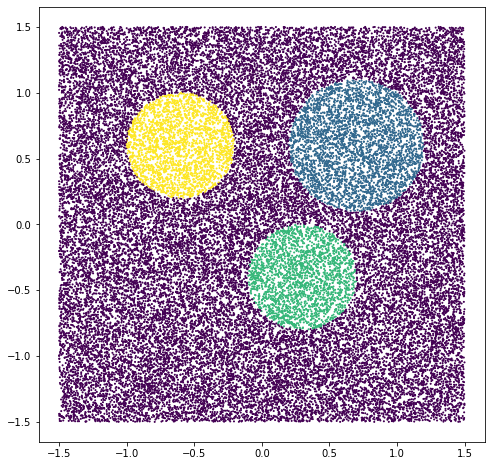

In [43]:
#Prepare data
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical

#Prepare data
N=40000
L=3
X = L*np.random.rand(N,2) 
X[:,0] = X[:,0]-L/2
X[:,1] = X[:,1]-L/2

Y = np.zeros(N)

for i in range(N):
    if (X[i,0]-0.7)**2+(X[i,1]-0.6)**2<0.25:
        Y[i]=1
    elif (X[i,0]-0.3)**2+(X[i,1]+0.4)**2<0.16:
        Y[i]=2
    elif (X[i,0]+0.6)**2+(X[i,1]-0.6)**2<0.16:
        Y[i]=3
    else:
        Y[i]=0
        
plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:, 1], s=1, c=Y)
plt.show()

data = X
labels = to_categorical(Y)

In [53]:
model = prepare_model([6,6,6],n_category=len(labels[0]))
model.fit(data, labels, epochs=10,batch_size=32)

Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 46us/sample - loss: 0.5680 - categorical_accuracy: 0.7933
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.2710 - categorical_accuracy: 0.8849
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.1515 - categorical_accuracy: 0.9388
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.1038 - categorical_accuracy: 0.9697
Epoch 5/10
40000/40000 [==============================] - 2s 47us/sample - loss: 0.0786 - categorical_accuracy: 0.9780
Epoch 6/10
40000/40000 [==============================] - 2s 48us/sample - loss: 0.0646 - categorical_accuracy: 0.9811
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 0.0566 - categorical_accuracy: 0.9835
Epoch 8/10
40000/40000 [==============================] - 2s 47us/sample - loss: 0.0509 - categorical_accuracy: 0.9846
Epoch 9/10
40000/40000 [=

In [54]:
from tensorflow.keras import backend as K

get_layer_output_functions = []
for layer_i in range(len(model.layers)):
    get_layer_output_functions.append(K.function(model.layers[0].input,model.layers[layer_i].output))

X_test = data_grid(200,2)
Y_test = model.predict(X_test)
Y_test = np.argmax(Y_test, axis=1)
colors = get_color(X_test)

activations = get_data_activation(X_test,get_layer_output_functions)
data_activation_color = get_data_color(activations,colors)

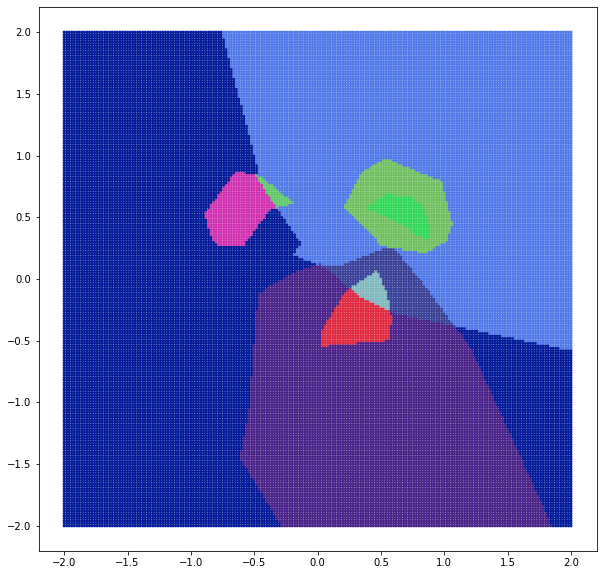

In [56]:
plt.figure(figsize=(10, 10))
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o',s=4, c=data_activation_color)
#plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=Y_test, s=1,alpha = 0.8)
plt.show()
plt.close()

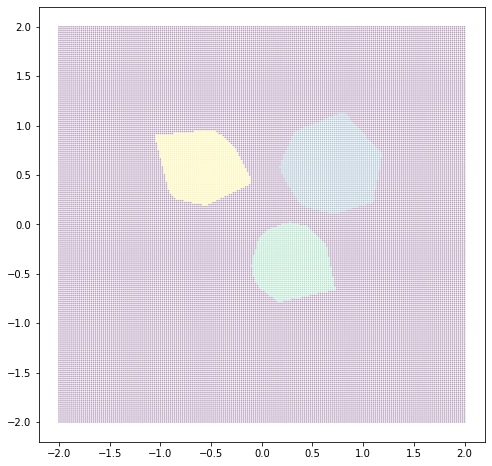

In [52]:
#test
import numpy as np

X_test = data_grid(200,2)
Y_test = model.predict(X_test)
Y_test = np.argmax(Y_test, axis=1)

plt.figure(figsize=(8, 8))
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=Y_test, s=0.5,alpha=0.3)
plt.show()
plt.close()

In [71]:
import activation_plot

In [72]:
activation_plot.get_color(X_test)

AttributeError: module 'activation_plot' has no attribute 'get_color'

In [61]:
from activation_plot import *

In [74]:
clear_line()